In [ ]:
# Classes File

In [1]:
# Local Import

import numpy as np
import pandas as pd
import math
import scipy.stats as ss
import numpy.linalg as la
from itertools import product
import numba as nb
#from pprint import pprint

%cd '/home/nbuser/library/example_code_implementation_guide/'

/home/nbuser/library/example_code_implementation_guide


In [2]:
# Plot Tools
import matplotlib.pyplot as plt
%matplotlib inline

from matplotlib import cycler
colors = cycler('color', 
       ['#EE6666', '#3388BB', '#9988DD', '#EECC55', 
       '#88BB44', '#FFBBBB'])

plt.rc('axes', facecolor='#E6E6E6', edgecolor='none',
      axisbelow=True, grid=True, prop_cycle=colors)
plt.rc('grid', color='w', linestyle='solid')
plt.rc('xtick', direction='out', color='gray')
plt.rc('ytick', direction='out', color='gray')
plt.rc('patch', edgecolor='#E6E6E6')
plt.rc('lines', linewidth=2)

In [3]:
# Test Data - Census Tract
data = pd.read_stata('private_data_by_cells.dta')

In [124]:
class func_repr:
    def __init__(self, β, SE, r=None, ϵ=None, χ=None):
        self.β = β
        self.SE = SE
        self.r = r
        self.ϵ = ϵ
        self.χ =χ

class FriedChetty:
    '''
    Chetty and Friedman Algorithm '''
    
    def __init__(self, data, method, ϵ=4):
        '''
        Organise data structure '''
        
        # Numpy-nize Census Tract
        self.C0 = np.unique(np.array([data['cell']]))
        self.rows = len(self.C0) 
        self.N = [len(data.loc[data.loc[:, 'cell']== i, 'kid_rank']) for i in self.C0]
        
        self.C1 = [np.array(data.loc[data.loc[:, 'cell']== i, 'kid_rank']) for i in self.C0]
        self.C2 = [np.array(data.loc[data.loc[:, 'cell']== i, 'parent_rank']) for i in self.C0]

        # Additional Rows
        col = len(data.keys()) - 1
        self.CD = np.array([list(i) for i in product([0, 1], repeat = col)])
        self.method = method
        self.ϵ = ϵ
    
    def Reg(self, q, weight=None, z=None):
        if weight != None:
            W = np.sqrt(np.diag(weight))
        else:
            if z!= None:
                W = np.identity(len(self.C1[q]) + 1)
            else:
                W = np.identity(len(self.C1[q]))
            
        if z != None:
            y = W @ np.concatenate((self.C1[q], self.CD[z][0]), axis=None)
            x = W @ np.concatenate((self.C2[q], self.CD[z][1]), axis=None)
            SE = None
        else:
            y = W @ self.C1[q]
            x = W @ self.C2[q]
            
        X = np.vstack([x, np.ones(len(x))]).T
        a, b = la.lstsq(X, y, rcond=None)[0]
        r = [m - n * a - b for m, n in zip(y, x)]
        
        if z == None:
            sₓ = np.sum([(m - np.mean(x)) ** 2 for m in x])
            SE = np.sqrt(np.dot(r, r) / (len(y) - 2) / sₓ)
        
        t = func_repr(β=a, SE=SE, r=r, ϵ=b)
        return t
    
    def MM(self, p, l=None):
        maxiter = 1000
        
        # 1. Ordinary Least Squares
        R_O = self.Reg(q=p, z=l)
        r = R_O.r
        L = len(r)
        
        # Convergence Loop
        for j in range(maxiter):
            
            # 3. Scale estimator ̂σᵢ
            if j == 0:
                absdev = []
                for i in range(L):
                    absdev.append(abs(r[i] - np.median(r)))
                scale = np.median(absdev) / ss.norm.ppf(0.75)
                β_temp = R_O.β
            if j != 0:
                K = 0.199
                scale = np.sqrt((w @ np.square(r)) / (L * K))
                β_temp = β

            # 4. Tukey's Bisquare Objective Function uᵢ
            u = np.divide(r, np.full(L, scale))

            # 5. Weights wᵢ , w/ Tuning constant 'c' for Tukey's Biweight
            c = 4.685
            w = []
            for i in range(L):
                if abs(u[i]) <= c:
                    w.append(((1 - (u[i] / c) ** 2) ** 2))
                else:
                    w.append(0)
            
            R_W = self.Reg(q=p, weight=w, z=l)
            β = R_W.β
            
            #7. Convergence
            if math.isclose(β, β_temp):
                break

        t = func_repr(β=β, SE=R_W.SE, ϵ=R_W.ϵ)
        return t
    
    # Modified Chetty Release Algorithm:
    def __call__(self):  
        '''
        Release Algorithm for Noise Infused Statistics '''
        
        # Store Variables
        θ = []
        SE_θ = []
        θ_d = np.zeros_like(self.C0)
        LS = np.zeros_like(self.C0)
        OSE = np.zeros_like(self.C0)

        for i in range(self.rows):
            
            if self.method == "OLS":
                R_1 = self.Reg(q=i)
            if self.method == "MM":
                R_1 = self.MM(p=i)
            
            θ.append(R_1.β)
            SE_θ.append(R_1.SE)

            # Compute Local Sensitivity (LS) for each cell:
            for j in range(0,4):

                if self.method == "OLS":
                    R_2 = self.Reg(q=i, z=j)
                if self.method == "MM":
                    R_2 = self.MM(p=i, l=j)
    
                # Store new statistic
                θ_d[i] = R_2.β

                # Compute Local Sensitivity as the max absolute difference
                if abs(θ_d[i] - θ[i]) > LS[i]:
                    LS[i] = abs(θ_d[i] - θ[i])
                    
                    # Figure 1 data
                    OSE[i] = LS[i] * self.N[i]
                    if OSE[i] == max(OSE):
                        # Data points
                        self.f1_p = np.vstack((self.C1[i], self.C2[i]))
                        self.f1_dp = np.vstack((self.CD[j][0], self.CD[j][1]))

                        # Regression Line
                        self.f1_r = lambda λ: R_1.β*λ + R_1.ϵ
                        self.f1_dr =  lambda λ: R_2.β*λ + R_2.ϵ
                        
                        # Print
                        self.cell = str(int(self.C0[i]))         
                        
        # 2. MOSE
        self.χ = max(OSE)
        
        # 3. Add Noise
        noise_θ = [a + np.sqrt(2) * (self.χ / (self.ϵ * b)) * np.random.laplace(0, 1 / np.sqrt(2)) for (a, b) in zip(θ, self.N)]

        SE_θ̃ = [np.sqrt(a ** 2 + 2 * ((self.χ / (self.ϵ * b)) ** 2)) for (a, b) in zip(SE_θ, self.N)]
        noise_SE_θ̃ = [a + np.sqrt(2) * (self.χ / (self.ϵ * b)) * np.random.laplace(0, 1 / np.sqrt(2)) for (a, b) in zip(SE_θ̃, self.N)]

        noise_N = [a + np.sqrt(2) * (np.random.laplace(0, 1 / np.sqrt(2)) / self.ϵ) for a in self.N]
        
        t = func_repr(β=noise_θ, SE=noise_SE_θ̃, r=noise_N, ϵ=self.ϵ, χ=self.χ)
        return t
    
    def plot(self, kind):
        fig, ax = plt.subplots(figsize = (8,6))
        
        if kind == "noise":
            # Figure 1
            ax.scatter(self.f1_p[1], self.f1_p[0])
            ax.scatter(self.f1_dp[1], self.f1_dp[0])
            l = np.linspace(0, 1, 5)
            ax.plot(l, self.f1_r(l), label="%s-Estimate in Actual Data"%self.method)
            ax.plot(l, self.f1_dr(l), linestyle = 'dashed', label="%s-Estimate with Outlier"%self.method)
            
            ax.set_title("FIGURE 1: Maximum Observed Sensitivity (χ = %s)"%str(self.χ), pad=35)
            ax.set_ylabel("Child's Income Rank for cell = %s"%self.cell)
            ax.set_xlabel("Parent's Income Rank for cell = %s"%self.cell)
            
            plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc='lower left',
            ncol=2, mode="expand", borderaxespad=0.)
            
        #if kind == "mose":
            # Figure 2
            
            
        
        #if kind == "sdl":
            # Figure 3
            
            
            
        #if kind == "reg":
            # Figure 4
            
    
        ax.set_ylim(-0.025, 1.025)
        ax.set_xlim(-0.025, 1.025)
        ax.grid(which='minor', color='w', alpha=0.3)            
        plt.show()    

In [125]:
# Test
Test1 = FriedChetty(data, method = "OLS")
Test2 = FriedChetty(data, method = "MM")

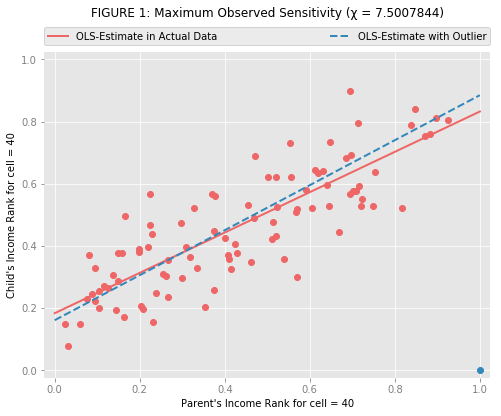

In [126]:
a1 = Test1()
Test1.plot("noise")

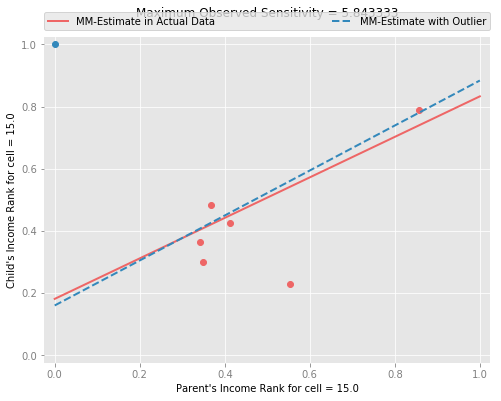

In [111]:
a2 = Test2()
Test2.plot("noise")